# Imports needed

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import percentile
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime
import matplotlib.dates as mdates
import operator
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from funcs import * 
import matplotlib

# Reads data, interpolate missing data and remove outliers 

In [2]:
#reads data 
data_df = pd.read_csv('Proj1_Dataset.csv', sep=',', decimal='.')
data_df=parse_date_time(data_df)

#remove outliers
data_df = drop_outliners(data_df, threshold=6,
                         collumn_to_remove_outliers=
                         ["S1Temp", "S2Temp","S3Temp",
                          "CO2","PIR1", "PIR2","S1Light",
                           "S2Light","S3Light"])


#interpolation
data_df = data_df.interpolate(method='linear', limit_direction='forward', axis=0)


#plot, for debugging 
#plot_data(data_df, temperature=True, CO2=True, PIR=True, light=True)

Removed outlined from index  56 from  S1Temp with value of: 0.0
Removed outlined from index  1188 from  S3Temp with value of: -12.32
Removed outlined from index  3760 from  S1Light with value of: 5500
Removed outlined from index  2800 from  S3Light with value of: 65536


# Reduces the number of parameters 

Inputs: "Temp", "Light", CO2 

Output: "Number of persons bigger than 2?" 

In [3]:
#groups temps and lights with the mean (input)
data_df["MeanTemp"] = data_df[["S1Temp", "S2Temp","S3Temp"]].mean(axis=1)
data_df["MeanLight"] = data_df[["S1Light", "S2Light","S3Light"]].mean(axis=1)

#places a new column with binary classification regarding the number of persons (output)
data_df["Result"] = np.select([data_df["Persons"] > 2, data_df["Persons"] <= 2] , [1,0])


#plot, for debugging 
#plot_data(data_df, temperature=True, Temp_join=True, CO2=True, PIR=False, PIR_Join = True, light=True, MeanLight=True, persons=True)


# Setup of the fuzzy sets 


D:\Programas\Anaconda\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
D:\Programas\Anaconda\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
D:\Programas\Anaconda\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
D:\Programas\Anaconda\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


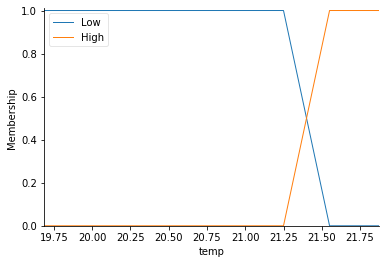

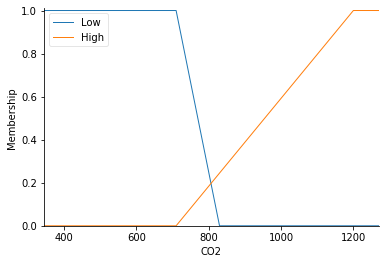

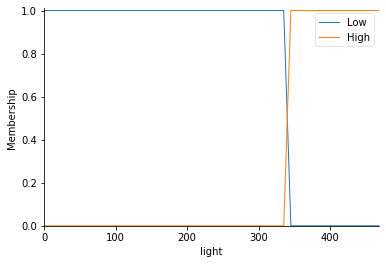

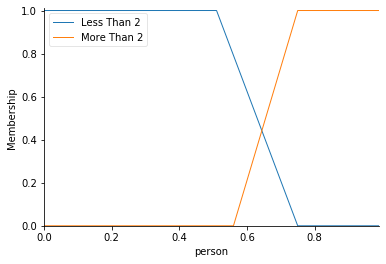

In [29]:
# Generate universe variables (temperature, CO2, PIR, Light and persons[binary])
x_temperature   = np.arange(data_df['MeanTemp'].min(), data_df['MeanTemp'].max(), 0.001)
x_CO2           = np.arange(data_df['CO2'].min(), data_df['CO2'].max()+1, 0.5)
x_light         = np.arange(data_df['MeanLight'].min(), data_df['MeanLight'].max()+1, 1)
y_person        = np.arange(0, 1, 0.01)

temp    = ctrl.Antecedent(x_temperature, 'temp')
CO2     = ctrl.Antecedent(x_CO2, 'CO2')
light   = ctrl.Antecedent(x_light, 'light')
person  = ctrl.Consequent(y_person, 'person')


#temp
min = x_temperature.min()
max = x_temperature.max()
med = min+((max-min)/2)

temp['Low'] = fuzz.trapmf(temp.universe, [min , min,  21.25, 21.55])
temp['High'] = fuzz.trapmf(temp.universe, [21.25 ,21.55, max , max ])


#CO2
min = x_CO2.min()
max = x_CO2.max()
med = min+((max-min)/2)

CO2['Low'] = fuzz.trapmf(CO2.universe, [min , min,  710 , 830])
CO2['High'] = fuzz.trapmf(CO2.universe, [710 ,1200, max , max ])


#light
min = x_light.min()
max = x_light.max()
med = min+((max-min)/2)

light['Low'] = fuzz.trapmf(light.universe, [min , min,  335, 345])
light['High'] = fuzz.trapmf(light.universe, [335 ,345, max , max ])


#person
person['Less Than 2'] = fuzz.trapmf(person.universe, [0,0,0.51,0.75])
person['More Than 2'] = fuzz.trapmf(person.universe, [0.56,0.75,1,1])


#view of fuzzysets 
temp.view()
CO2.view()
light.view()
person.view()



# Rule creation and classification

In [32]:
# Define rules
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, r2_score, f1_score
r1  = ctrl.Rule(light['High'], person['More Than 2'])
r2  = ctrl.Rule(light['Low'] & temp['High'] & CO2['High'], person['More Than 2'])
r3  = ctrl.Rule(light['Low'] & temp['High'] & CO2['Low'], person['Less Than 2'])
r4  = ctrl.Rule(light['Low'] & temp['Low'] & CO2['High'], person['More Than 2'])
r5  = ctrl.Rule(light['Low'] & temp['Low'] & CO2['Low'], person['Less Than 2'])


# add rules to control system
person_ctrl = ctrl.ControlSystem([r1, r2, r3, r4, r5])
# Create simulation
person_sim = ctrl.ControlSystemSimulation(person_ctrl)


#vector of the prediction
y_pred = []

for row in data_df.iterrows():
    person_sim.input['temp'] = row[1]['MeanTemp']
    person_sim.input['CO2'] = row[1]['CO2']
    person_sim.input['light'] = row[1]['MeanLight']
    
    # Crunch the numbers
    person_sim.compute()

    #generates binary output based on a treshold 
    if person_sim.output['person'] > 0.81:
        y_pred.append(1)
    else:
        y_pred.append(0)
    
#converts the binary classification into a list to be compared with the prediction
y_real = data_df['Result'].to_list()


#print of the results 
print("Results of the classification using fuzzy sets")
print("Accuracy:",accuracy_score(y_real, y_pred))
print("Precision:",precision_score(y_real, y_pred, average='macro'))
print("Recall:",recall_score(y_real, y_pred, average='macro'))
print("F1:", f1_score(y_real, y_pred, average='macro'))
print("Confusion:\n",confusion_matrix(y_real, y_pred))    
print("\n")
 

Results of the classification using fuzzy sets
Accuracy: 0.9692839506172839
Precision: 0.9041157105612064
Recall: 0.873059721576658
F1: 0.8878335778900626
Confusion:
 [[9221  123]
 [ 188  593]]




# Comparison with  NN

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

x_train, x, y_train, y = train_test_split(data_df[["CO2","MeanTemp", "MeanLight"]], data_df["Result"], random_state=113, test_size=0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x, y, test_size=0.5, random_state=1, shuffle = True)

x_train_val, x_train_min, x_train_max = normalize_train_set(x_train)

x_test = normalize_test_set(x_test, x_train_min, x_train_max)
x_valid = normalize_test_set(x_valid, x_train_min, x_train_max)

clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=([7,3]), random_state=53, learning_rate_init=0.04)
clf.fit(x_train, y_train)


#validation
y_pred_valid=clf.predict(x_valid)  

print("Validation")
print("Accuracy:",accuracy_score(y_valid, y_pred_valid))
print("Precision:",precision_score(y_valid, y_pred_valid, average='macro'))
print("Recall:",recall_score(y_valid, y_pred_valid, average='macro'))
print("F1:", f1_score(y_valid, y_pred_valid, average='macro'))
print("Confusion:\n",confusion_matrix(y_valid, y_pred_valid))    
print("\n")


#test 
y_pred_test=clf.predict(x_test)

print("Test")
print("Accuracy:",accuracy_score(y_test, y_pred_test))
print("Precision:",precision_score(y_test, y_pred_test, average='macro'))
print("Recall:",recall_score(y_test, y_pred_test, average='macro'))
print("F1:", f1_score(y_test, y_pred_test, average='macro'))
print("Confusion:\n",confusion_matrix(y_test, y_pred_test))    
print("\n")



C:\Users\Resende\Downloads\proj\funcs.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[collumn] = (data_df[collumn] - min_array[i]) / (max_array[i] - min_array[i])


Validation
Accuracy: 0.9637919684002634
Precision: 0.9378958479943702
Recall: 0.8263781845429243
F1: 0.8721703273584112
Confusion:
 [[1375    9]
 [  46   89]]


Test
Accuracy: 0.9697169190256748
Precision: 0.9370538838348496
Recall: 0.8400083475483613
F1: 0.8812958684425116
Confusion:
 [[1392    9]
 [  37   81]]


